In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import dlsim, butter, lfilter, welch
import scienceplots
import pandas as pd
import cvxpy as cp

import virtual_sensors as vs
import virtual_sensors.problems.svr as svr

In [2]:
# print settings
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

## Load data

In [3]:
# Error correction
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_step = np.loadtxt("data/masters_data2/step_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_step = np.loadtxt("data/masters_data2/step_sensor.csv", delimiter=",")


## Create data frames
The two dataframes aare merged and interpolated to a constant sampling time 1ms.

In [4]:
# sensor data
sensor_column_names = ['Time', 'Encoder 1','Encoder 2','Torque 1', 'Torque 2']
sensor_df = pd.DataFrame(data=sensor_data_step, columns=sensor_column_names)
sensor_df['Time'] = pd.to_timedelta(sensor_df['Time'], unit='s')

# motor data
motor_columns_names = ['Time', 'Motor 1 setpoint ', 'Motor 1', 'Motor 2 setpoint', 'Motor 2']
motor_df = pd.DataFrame(data=motor_data_step, columns=motor_columns_names)
motor_df['Time'] = pd.to_timedelta(motor_df['Time'], unit='s')

# initialize estimates
motor_df['Motor 1 estimate'] = None
motor_df['Motor 2 estimate'] = None
sensor_df['Encoder 1 estimate'] = None
sensor_df['Encoder 2 estimate'] = None
sensor_df['Torque 1 estimate'] = None


## Construct state-space Model

In [5]:
# get sampling time
dt = float(sensor_df['Time'].diff().dropna().mean().total_seconds())
dt2 = float(motor_df['Time'].diff().dropna().mean().total_seconds())
print(dt, dt2)

inertias, stiffs, damps, damps_ext, ratios = vs.new_parameters()
A, B, C, D = vs.state_space_matrices(inertias, stiffs, damps, damps_ext, ratios, full_B=False, gear_B=False)
sys = vs.ContinuousSystem(A,B,C,D)
sysd = vs.c2d(sys,dt)


0.000996 0.001016


## Construct the Optimization Problem

In [6]:
############################################################
BATCH_SIZE = 500
lam = 1
eps = 0.2
############################################################

n_states, n_inputs, n_outputs = sysd.get_dims()

#calculate parameters
O, Gamma = sysd.dataeq(BATCH_SIZE)
D2 = vs.second_difference_matrix(BATCH_SIZE, n_inputs)
x0 = np.zeros((n_states,1))
y = np.zeros((n_outputs*BATCH_SIZE,1))

pars = svr.Parameters(y, x0, O, Gamma, D2, lam, eps)
vars = svr.Variables(BATCH_SIZE, n_inputs, n_outputs)
problem = svr.Problem(vars, pars)


## Solve batch problems

In [7]:
DATA_SIZE = len(sensor_df)
'''
problem.pars.x0 = np.array(
[[210],
 [210],
 [210],
 [210],
 [210],
 [210],
 [210],
 [210],
 [210],
 [210],
 [210],
 [210],
 [ 70],
 [ 70],
 [ 70],
 [ 70],
 [ 70],
 [ 17],
 [ 17],
 [ 17],
 [ 17],
 [ 17],
 [ 1.5],
 [ 1.5],
 [ 1.5],
 [ 1.5],
 [ 1.5],
 [ 1.5],
 [ 1.5],
 [ 1.5],
 [ 1.5],
 [ 1.5],
 [ 1.5],
 [ 1.5],
 [ 6],
 [ 6],
 [ 6],
 [ 6],
 [ 6],
 [ 6],
 [ 6],
 [ 6],
 [ 6]])
 '''
problem.pars.x0 = x0
problem.update()

for start in range(0, int(DATA_SIZE/10) - DATA_SIZE % BATCH_SIZE, BATCH_SIZE):
    end = start + BATCH_SIZE
    batch_df = sensor_df.iloc[start:end]
    df_y = batch_df[['Encoder 1','Encoder 2','Torque 1']]

    t = batch_df['Time'].dt.total_seconds().to_numpy()
    y = np.array(df_y).flatten().reshape(-1,1) #reshape from (n,) to (n,1)

    # update y
    problem.pars.y = y
    problem.update()

    #solve the problem
    problem.solve()
    uhat = np.array(problem.vars.u.value).reshape(-1,2)
    yhat = np.array(problem.pars.Gamma @ problem.vars.u.value).reshape(-1,3)

    # store result in df
    motor_df.iloc[start:end, motor_df.columns.get_loc('Motor 1 estimate')] = uhat[:, 0]
    motor_df.iloc[start:end, motor_df.columns.get_loc('Motor 2 estimate')] = uhat[:, 1]
    sensor_df.iloc[start:end, sensor_df.columns.get_loc('Encoder 1 estimate')] = yhat[:, 0]
    sensor_df.iloc[start:end, sensor_df.columns.get_loc('Encoder 2 estimate')] = yhat[:, 1]
    sensor_df.iloc[start:end, sensor_df.columns.get_loc('Torque 1 estimate')] = yhat[:, 2]

    #update x0 with last state estimate in batch
    #x = problem.pars.x0
    #for k in range(BATCH_SIZE):
    #    u = uhat[k].reshape(-1,1)
    #    x = sysd.A @ x + sysd.B @ u
    #problem.pars.x0 = x
    


prob solved 
prob solved 


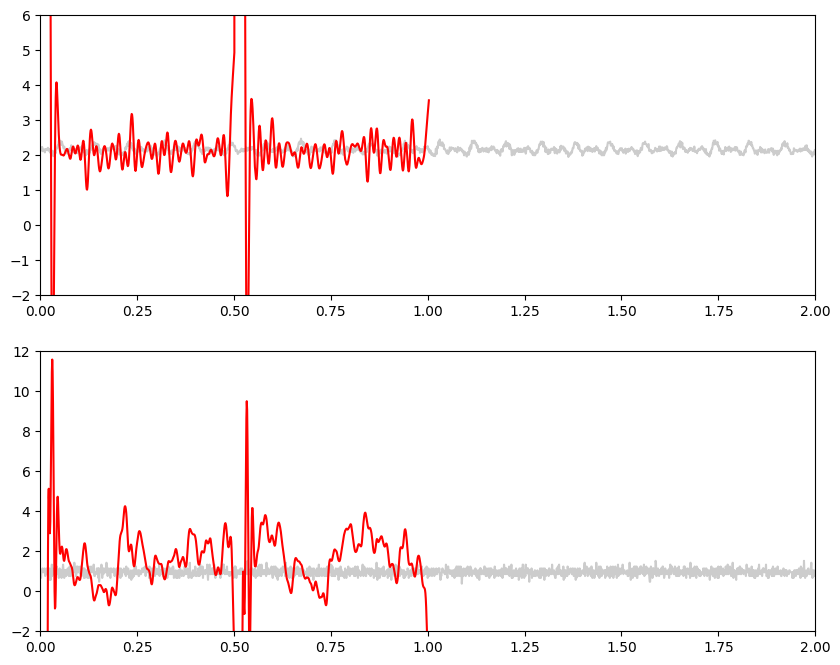

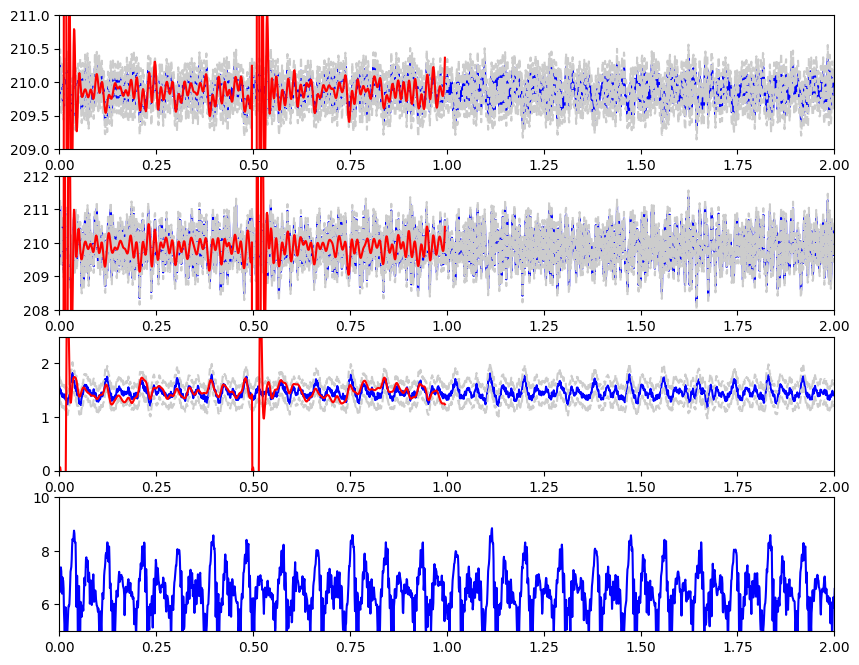

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(motor_df['Time'].dt.total_seconds().to_numpy(), motor_df['Motor 1'], color=[0.8,0.8,0.8])
axs[0].plot(motor_df['Time'].dt.total_seconds().to_numpy(), motor_df['Motor 1 estimate'], color='red')
axs[0].set_ylim(-2,6)
axs[0].set_xlim(0,2)

axs[1].plot(motor_df['Time'].dt.total_seconds().to_numpy(), motor_df['Motor 2'], color=[0.8,0.8,0.8])
axs[1].plot(motor_df['Time'].dt.total_seconds().to_numpy(), motor_df['Motor 2 estimate'], color='red')
axs[1].set_ylim(-2,12)
axs[1].set_xlim(0,2)

plt.show()

fig, axs = plt.subplots(4, 1, figsize=(10, 8))
axs[0].plot(sensor_df['Time'].dt.total_seconds().to_numpy(), sensor_df['Encoder 1'], color='blue')
axs[0].plot(sensor_df['Time'].dt.total_seconds().to_numpy(), sensor_df['Encoder 1']+pars.eps, color='black', linestyle='--')
axs[0].plot(sensor_df['Time'].dt.total_seconds().to_numpy(), sensor_df['Encoder 1']-pars.eps, color='black', linestyle='--')
axs[0].plot(sensor_df['Time'].dt.total_seconds().to_numpy(), sensor_df['Encoder 1 estimate'], color='red')
axs[0].set_xlim(0,2)
axs[0].set_ylim(209,211)

axs[1].plot(sensor_df['Time'].dt.total_seconds().to_numpy(), sensor_df['Encoder 2'], color='blue')
axs[1].plot(sensor_df['Time'].dt.total_seconds().to_numpy(), sensor_df['Encoder 2']+pars.eps, color='black', linestyle='--')
axs[1].plot(sensor_df['Time'].dt.total_seconds().to_numpy(), sensor_df['Encoder 2']-pars.eps, color='black', linestyle='--')
axs[1].plot(sensor_df['Time'].dt.total_seconds().to_numpy(), sensor_df['Encoder 2 estimate'], color='red')
axs[1].set_xlim(0,2)
axs[1].set_ylim(208,212)

axs[2].plot(sensor_df['Time'].dt.total_seconds().to_numpy(), sensor_df['Torque 1'], color='blue')
axs[2].plot(sensor_df['Time'].dt.total_seconds().to_numpy(), sensor_df['Torque 1']+pars.eps, color='black', linestyle='--')
axs[2].plot(sensor_df['Time'].dt.total_seconds().to_numpy(), sensor_df['Torque 1']-pars.eps, color='black', linestyle='--')
axs[2].plot(sensor_df['Time'].dt.total_seconds().to_numpy(), sensor_df['Torque 1 estimate'], color='red')
axs[2].set_xlim(0,2)
axs[2].set_ylim(0,2.5)

axs[3].plot(sensor_df['Time'].dt.total_seconds().to_numpy(), sensor_df['Torque 2'], color='blue')
axs[3].set_xlim(0,2)
axs[3].set_ylim(5,10)
plt.show()

(0.0, 2.0)

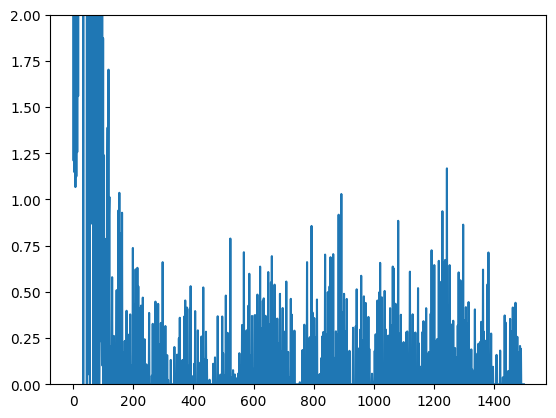

In [9]:
plt.plot(np.abs(problem.vars.zeta.value+problem.vars.zeta_ast.value))
plt.ylim(0,2)